In [15]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

In [16]:
import os
import pickle

raw_files = [(x[0], x[2]) for x in os.walk('../exh-b-o-comparison')][0]
raw_files

('../exh-b-o-comparison',
 ['Exh+E.txt', 'Exh+E+B.txt', 'Exh+E+B+O.txt', 'Exh+E+B+O+ID.txt'])

In [17]:
from collections import defaultdict
import pandas as pd
import re
result_maps = dict()
map_types = set()
for file in raw_files[1]:
    name = os.path.splitext(file)[0]
#     print(name)
    df = pd.read_csv("../exh-b-o-comparison/" + file)
    result_maps[name] = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
    results = result_maps[name]
    for d in df.iterrows():
        data = d[1]
        setting = data[0]
#         print(setting)
        m = re.match('([A-Za-z0-9]*)-20x20-A(\d+)_T(\d+)',setting)
        map_type = m.group(1)
        map_types.add(map_type)
        agents = int(m.group(2))
        teams = int(m.group(3))
#         print(map_type,agents,teams)
        results[map_type][teams][agents] = (data[2],data[1])
    print(results)
#     print(results)
# print(result_maps)
#         t = data[]
#         print(data[0])
#     print(df)
    
    

defaultdict(<function <lambda> at 0x7f65e02b7430>, {'25': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7f65e0586d30>, {1: defaultdict(<class 'dict'>, {1: (0.0277781173790572, 1.0), 2: (0.1422902309786877, 1.0), 3: (0.4946847929205978, 1.0), 4: (4.464744824961818, 1.0), 5: (35.8325178909392, 1.0), 6: (120.03028177933942, 0.0)}), 3: defaultdict(<class 'dict'>, {1: (0.0256675133007229, 1.0), 2: (0.0692950503400061, 1.0), 3: (0.0985927241801982, 1.0), 4: (0.442538561062247, 1.0), 5: (1.7807991332592792, 1.0), 6: (10.600994839080377, 0.96), 7: (24.37970431487949, 1.0), 8: (93.2594782788804, 0.64), 9: (120.03656420807964, 0.0)})}), '75': defaultdict(<function <lambda>.<locals>.<lambda> at 0x7f65e0586ee0>, {1: defaultdict(<class 'dict'>, {1: (0.009369383919402, 1.0), 2: (0.9085959181989892, 1.0), 3: (43.09035470088042, 0.72), 4: (104.34168322050216, 0.18), 5: (120.03300411115896, 0.0)}), 3: defaultdict(<class 'dict'>, {1: (0.0063848912410321, 1.0), 2: (0.9797743757610442, 1.0), 3: (2

1
75


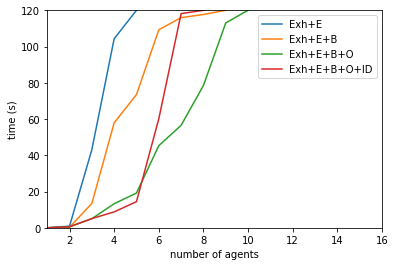

25


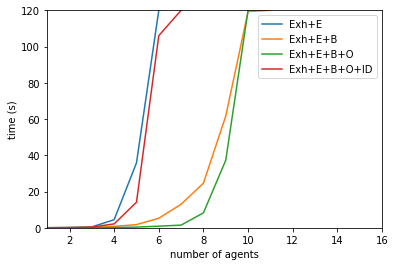

3
75


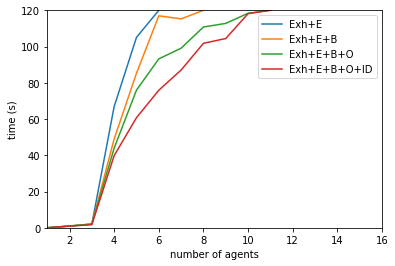

25


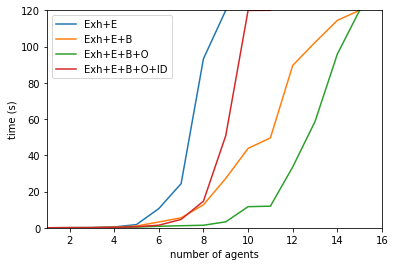

1
75


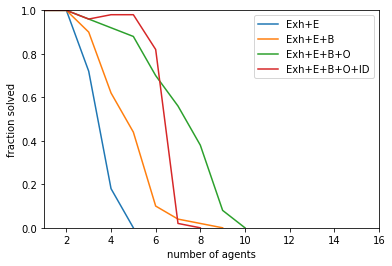

25


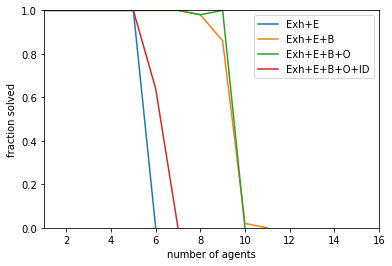

3
75


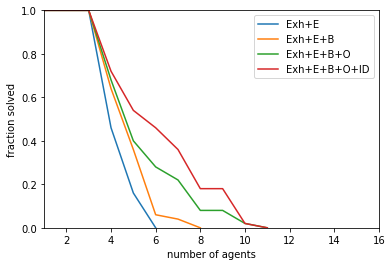

25


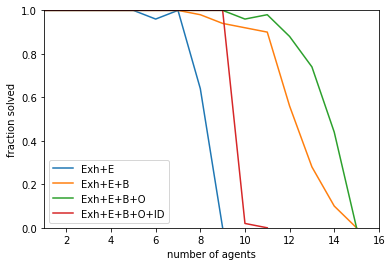

In [22]:
for team_size in [1,3]:
    print(team_size)
    for map_type in map_types:
        plt.axis([1, 16, 0, 120])
        print(map_type)
        for name in result_maps:
            data = result_maps[name][map_type][team_size]
#             print(result_maps[name][map_type][team_size])
            keys = list(data.keys())
            values = list(map(lambda x: x[0],data.values()))
#             print(times)
            plt.plot(keys,values, label = name)
        plt.xlabel('number of agents')
        plt.ylabel('time (s)')
        plt.legend()
        plt.savefig("{}-{}".format(map_type.lower(),team_size))
        plt.show()
for team_size in [1,3]:
    print(team_size)
    for map_type in map_types:
        plt.axis([1, 16, 0, 1])
        print(map_type)
        for name in result_maps:
            data = result_maps[name][map_type][team_size]
#             print(result_maps[name][map_type][team_size])
            keys = list(data.keys())
            values = list(map(lambda x: x[1],data.values()))
#             print(times)
            plt.plot(keys,values, label = name)
        plt.xlabel('number of agents')
        plt.ylabel('fraction solved')
        plt.legend()
        plt.savefig("{}-{}-p".format(map_type.lower(),team_size))
        plt.show()

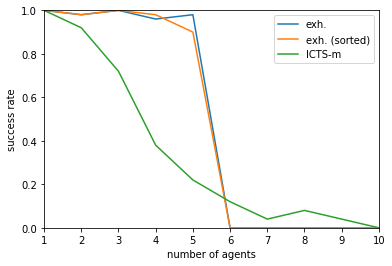

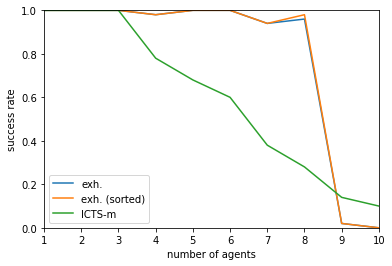

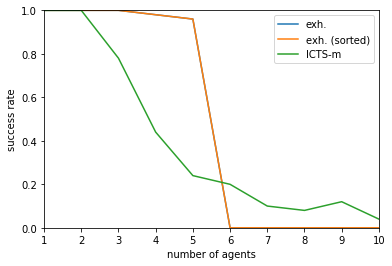

ValueError: x and y must have same first dimension, but have shapes (8,) and (10,)

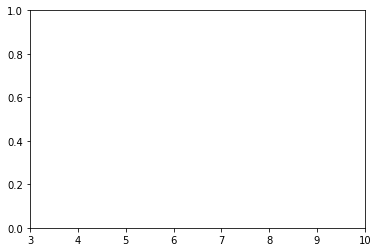

In [21]:
# data = np.arange(60)
solvers = dict()
solvers["exh."] = dict()
solvers["exh. (sorted)"] = dict()
solvers["ICTS-m"] = dict()

one_results = dict()
one_results["open"] = dict()
one_results["obstacles"] = dict()
three_results = dict()
three_results["open"] = dict()
three_results["obstacles"] = dict()
for (algo,path) in [("exh.","enum_results.txt"),("exh. (sorted)","enum_sorted_results.txt"),("ICTS-m","results.txt")]:
    df = pd.read_csv("../results/map-sets/" + path)
    data = df[["completed","avg","std"]].to_numpy()
    one_results["open"][algo] = data[0:10]
    three_results["open"][algo] = data[10:20]
    one_results["obstacles"][algo] = data[20:30]
    three_results["obstacles"][algo] = data[30:40]

plt.axis([1, 10, 0, 1])
for k in one_results["open"]:
    plt.plot(list(range(1,11)),one_results["open"][k][:,0], label = k)
plt.xlabel('number of agents')
plt.ylabel('success rate')
plt.legend()
plt.show()

plt.axis([1, 10, 0, 1])
for k in three_results["open"]:
    plt.plot(list(range(1,11)),three_results["open"][k][:,0], label = k)
plt.xlabel('number of agents')
plt.ylabel('success rate')
plt.legend()
plt.show()

plt.axis([1, 10, 0, 1])
for k in one_results["obstacles"]:
    plt.plot(list(range(1,11)),one_results["obstacles"][k][:,0], label = k)
plt.xlabel('number of agents')
plt.ylabel('success rate')
plt.legend()
plt.show()

plt.axis([3, 10, 0, 1])
for k in three_results["obstacles"]:
    plt.plot(list(range(3,11)),three_results["obstacles"][k][:,0], label = k)
plt.xlabel('number of agents')
plt.ylabel('success rate')
plt.legend()
plt.show()
# plt.axis([1, 10, 0, 1])
# for k in one_results:
# #     print(k,results_map["open"][k])
#     plt.plot(list(range(1,11)),three_results[k][:,0], label = k)
# plt.xlabel('number of agents')
# plt.ylabel('success rate')
# plt.legend()
# plt.show()

#         print(data[20 * i + 1:20 + 20 * i:2])

NameError: name 'one_results' is not defined

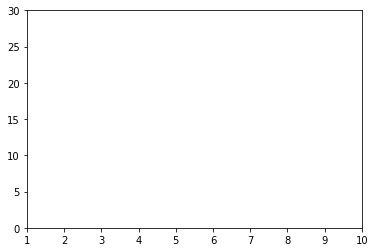

In [5]:
plt.axis([1, 10, 0, 30])
for k in one_results["open"]:
    plt.plot(list(range(1,11)),one_results["open"][k][:,1], label = k)
plt.xlabel('number of agents')
plt.ylabel('time (s)')
plt.legend()
plt.show()

plt.axis([1, 10, 0, 30])
for k in three_results["open"]:
    plt.plot(list(range(1,11)),three_results["open"][k][:,1], label = k)
plt.xlabel('number of agents')
plt.ylabel('time (s)')
plt.legend()
plt.show()

plt.axis([1, 10, 0, 30])
for k in one_results["obstacles"]:
    plt.plot(list(range(1,11)),one_results["obstacles"][k][:,1], label = k)
plt.xlabel('number of agents')
plt.ylabel('time (s)')
plt.legend()
plt.show()

plt.axis([3, 10, 0, 30])
for k in three_results["obstacles"]:
    plt.plot(list(range(3,11)),three_results["obstacles"][k][:,1], label = k)
plt.xlabel('number of agents')
plt.ylabel('time (s)')
plt.legend()
plt.show()